# Training With Additional Dataset
<p>Additional dataset from Allen's own keystroke dynamic is captured and added into the benchmark dataset for training and more in depth evaluation using Support Vector Machine and Gradient Boost Ensemble algorithm.
These 2 algorithms are identified to have the highest accuracy results among all the other models evaluated in the inital screening exercise.</p>
<p>The following exercise will attempt to incorporate our own captured keystroke data and performance hyperparameter tuning using these 2 algorithm to derive the best performing algorithm for our finalised model for deployment. </p>

In [2]:
# Import all required libraries
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import model selection and data preparation libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

# Import algorithm libraries
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

## Loading of Datasets

#### 1) Loading Allen's keystroke data

In [3]:
# Loading Allen's keystroke data 
new_df = pd.read_csv('./Keystroke Data/Allen-keystroke_combined.csv')

# Get the dataframe for feature columns only
# Conversion from millisec to second
new_features = new_df.drop(['User','Session', 'Sequence'], axis=1) / 1000.0
new_target = new_df['User']

new_features

,H.period,UD.period.t,H.t,UD.t.i,H.i,UD.i.e,H.e,UD.e.five,H.five,UD.five.Shift.r,...,UD.Shift.r.o,H.o,UD.o.a,H.a,UD.a.n,H.n,UD.n.l,H.l,UD.l.Return,H.Return
0,0.131,0.131,0.091,0.063,0.091,0.100,0.101,0.161,0.115,0.321,...,0.003,0.088,0.090,0.132,0.003,0.077,0.154,0.071,0.130,0.071
1,0.131,0.134,0.082,0.070,0.071,0.019,0.091,0.144,0.071,0.342,...,0.130,0.082,0.059,0.112,0.080,0.074,0.180,0.072,0.181,0.073
2,0.121,0.115,0.081,0.070,0.071,0.019,0.091,0.265,0.101,0.347,...,0.121,0.080,0.060,0.125,0.060,0.062,0.170,0.062,0.193,0.071
3,0.121,0.130,0.092,0.073,0.081,0.029,0.081,0.191,0.124,0.292,...,0.123,0.081,0.080,0.111,0.070,0.071,0.164,0.081,0.090,0.081
4,0.122,0.090,0.091,0.063,0.081,0.040,0.101,0.161,0.095,0.312,...,0.144,0.090,0.050,0.111,0.030,0.082,0.143,0.051,0.150,0.051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,0.144,-0.003,0.118,0.080,0.092,0.069,0.092,0.137,0.091,0.292,...,0.070,0.091,0.071,0.120,0.050,0.088,0.172,0.101,0.120,0.072
410,0.132,0.049,0.102,0.107,0.091,0.090,0.112,0.127,0.091,0.334,...,0.110,0.082,0.069,0.082,0.070,0.098,0.150,0.081,0.131,0.061
411,0.123,0.120,0.098,0.070,0.102,0.060,0.111,0.137,0.112,0.312,...,0.070,0.112,0.029,0.112,0.060,0.098,0.142,0.081,0.101,0.091
412,0.121,0.161,0.111,0.051,0.088,0.060,0.122,0.111,0.101,0.289,...,0.101,0.098,0.070,0.101,0.050,0.102,0.157,0.071,0.120,0.062


#### 2) Loading benchmark keystroke data

In [4]:
# Loading benchmark dataset and only taking data from first 10 subjects
benchmark_df = pd.read_csv('./Keystroke Data/DSL-StrongPasswordData.csv')
first_10subject = (benchmark_df.groupby(by='subject', axis=0).count().index[:10])
selected_dataset = benchmark_df[benchmark_df['subject'].isin(first_10subject)]

# The DD and UD timings of each key have been showed to be highly correlated to each other 
# in a separate analysis. Hence, we will drop all features starting with 'DD'
all_features = selected_dataset.columns[3:34]
benchmark_features = [x for x in all_features if not x.startswith('DD')]
benchmark_target = selected_dataset['subject']



#### 3) Consolidating dataset

In [5]:
# Get a copy of dataset with selected feature columns
df = selected_dataset[benchmark_features].copy()

# Concatenate both DataFrame for feature columns
df = pd.concat([df, new_features])

# Concatenate both target columns
df_target = pd.concat([benchmark_target, new_target ])


# check for invalid/missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4414 entries, 0 to 413
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   H.period         4414 non-null   float64
 1   UD.period.t      4414 non-null   float64
 2   H.t              4414 non-null   float64
 3   UD.t.i           4414 non-null   float64
 4   H.i              4414 non-null   float64
 5   UD.i.e           4414 non-null   float64
 6   H.e              4414 non-null   float64
 7   UD.e.five        4414 non-null   float64
 8   H.five           4414 non-null   float64
 9   UD.five.Shift.r  4414 non-null   float64
 10  H.Shift.r        4414 non-null   float64
 11  UD.Shift.r.o     4414 non-null   float64
 12  H.o              4414 non-null   float64
 13  UD.o.a           4414 non-null   float64
 14  H.a              4414 non-null   float64
 15  UD.a.n           4414 non-null   float64
 16  H.n              4414 non-null   float64
 17  UD.n.l         

#### 4) Encoding target labels

In [6]:
# Encode all target labels into integers
enc = LabelEncoder()
df_target_int = enc.fit_transform(df_target)

print("Classes:", enc.classes_)


Classes: ['Allen' 's002' 's003' 's004' 's005' 's007' 's008' 's010' 's011' 's012'
 's013']


#### 5) Dataset visualisations

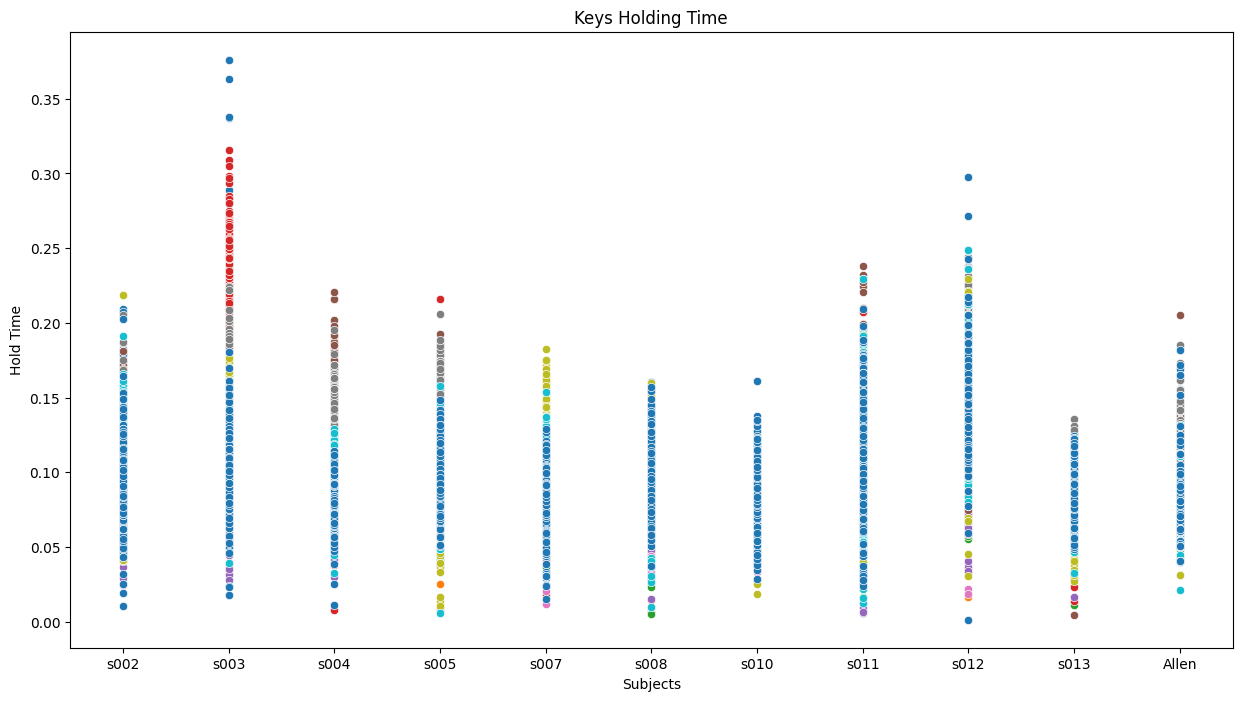

In [7]:
# Plot scatter graph for visualisation on Hold time
# Select only the hold times
hold_col = [x for x in df.columns if x.startswith('H')]

hold_dataset = df[hold_col]
hold_dataset.index = df_target

# creating subplots to overlay the timings
fig, ax = plt.subplots(figsize=(15,8))

for h in hold_col:
    ax = sns.scatterplot(hold_dataset, x=hold_dataset.index, y=h)
    
ax.set(xlabel="Subjects", ylabel="Hold Time", title='Keys Holding Time')
plt.show()

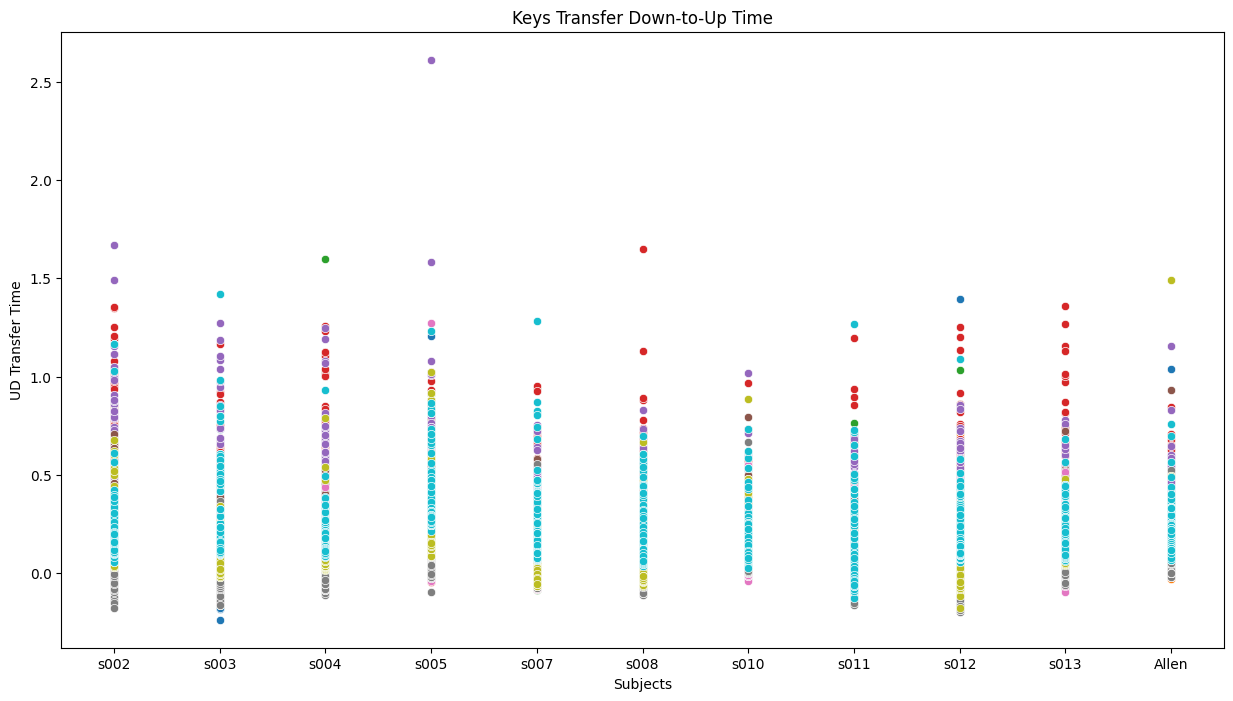

In [8]:
# Plot scatter graph for visualisation on UD time
# Select only the UD times
UD_col = [x for x in df.columns  if x.startswith('UD')]

UD_dataset = df[UD_col]
UD_dataset.index = df_target

# creating subplots to overlay the timings
fig, ax = plt.subplots(figsize=(15,8))

for h in UD_dataset:
    ax = sns.scatterplot(UD_dataset, x=UD_dataset.index, y=h)
    
ax.set(xlabel="Subjects", ylabel="UD Transfer Time", title='Keys Transfer Down-to-Up Time')
plt.show()

## Splitting Data into Training and Test Sets & Scaling

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df, df_target_int, test_size=0.25, random_state=42,
                                                   stratify=df_target_int)

# Applying scaling to training dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)



## Creation of Experiment for MLFlow Logging

### A) Suport Vector Classifier

### 1) Using RBF Kernel

In [95]:
mlflow.sklearn.autolog()

experiment_name = "Evaluation Experiment on SVM"
experiment = mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name="RBF Kernel", experiment_id=experiment.experiment_id):

    # Create Pipeline for scaling and SVC model on rgf kernel
    mypipeline = Pipeline([("scaler", StandardScaler()),("svm", SVC(random_state=42))])

    # Run grid search
    param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
                 'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

    grid = GridSearchCV(mypipeline, param_grid=param_grid, cv=10)
    grid.fit(X_train, y_train)


    run_id = mlflow.last_active_run().info.run_id
    print("Logged data and model in run {}".format(run_id))


2023/08/14 22:59:58 INFO mlflow.sklearn.utils: Logging the 5 best runs, 31 runs will be omitted.


Logged data and model in run 4326feb43a7145fe87dc32ec5b94e715


In [96]:
# Print results of run
print("Best cross validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))


Best cross validation accuracy: 0.94
Test set score: 0.93
Best parameters: {'svm__C': 10, 'svm__gamma': 0.01}


In [ ]:
grid.cv_results_

2023/08/14 23:01:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7835918ec7bb49dfabbda575dfcc8721', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Confusion matrix:
[[96  4  0  0  3  0  1  0  0  0  0]
 [ 2 90  3  0  1  1  1  0  1  1  0]
 [ 1  2 90  2  0  1  1  0  2  1  0]
 [ 0  6  1 91  0  1  0  0  1  0  0]
 [ 0  1  2  0 96  0  0  0  1  0  0]
 [ 0  1  1  0  0 92  5  0  1  0  0]
 [ 2  0  1  1  0  2 93  0  1  0  0]
 [ 1  0  0  0  0  0  0 98  0  0  1]
 [ 0  2  1  0  0  2  1  0 91  3  0]
 [ 0  2  3  0  0  1  1  0  0 93  0]
 [ 0  2  0  0  0  0  1  2  0  0 95]]


[Text(0.5, 23.52222222222222, 'Predicted Class'),
 Text(50.722222222222214, 0.5, 'True Class'),
 Text(0.5, 1.0, 'Confusion Matrix')]

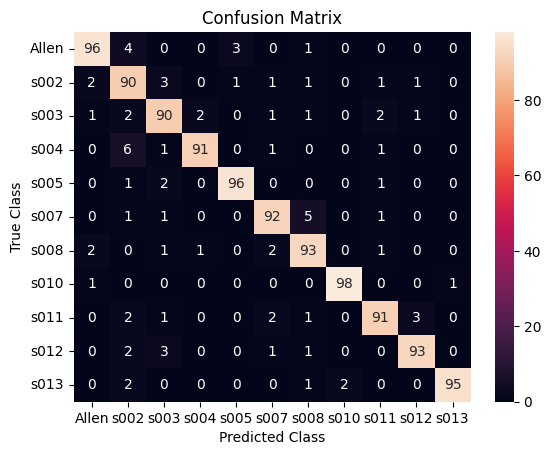

In [97]:
# Measure confusion matric on test data
best_pipeline = Pipeline([("scaler", StandardScaler()),("svm", SVC(C=grid.best_params_['svm__C']
                                                                   ,gamma=grid.best_params_['svm__gamma']
                                                                   ,kernel='rbf'))])
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

print("Confusion matrix:\n{}".format(confusion_matrix(y_test,y_pred)))

score_image1 = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, xticklabels=enc.classes_,
                          yticklabels=enc.classes_)
score_image1.set(xlabel='Predicted Class', ylabel='True Class', title='Confusion Matrix')


In [98]:
# Classification reporting
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       104
           1       0.82      0.90      0.86       100
           2       0.88      0.90      0.89       100
           3       0.97      0.91      0.94       100
           4       0.96      0.96      0.96       100
           5       0.92      0.92      0.92       100
           6       0.89      0.93      0.91       100
           7       0.98      0.98      0.98       100
           8       0.93      0.91      0.92       100
           9       0.95      0.93      0.94       100
          10       0.99      0.95      0.97       100

    accuracy                           0.93      1104
   macro avg       0.93      0.93      0.93      1104
weighted avg       0.93      0.93      0.93      1104



### 2) Using polynomial kernel

In [100]:
with mlflow.start_run(run_name="Polynomial Kernel", experiment_id=experiment.experiment_id):

    # Create Pipeline for scaling and SVC model on polynomial kernel
    mypipeline2 = Pipeline([("scaler", StandardScaler()),("svm", SVC(kernel='poly', random_state=42))])

    # Run grid search
    param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
             'svm__degree': [1, 2, 3, 4, 5]}
    grid = GridSearchCV(mypipeline2, param_grid=param_grid, cv=10)
    grid.fit(X_train, y_train)


    run_id = mlflow.last_active_run().info.run_id
    print("Logged data and model in run {}".format(run_id))


2023/08/14 23:17:30 INFO mlflow.sklearn.utils: Logging the 5 best runs, 25 runs will be omitted.


Logged data and model in run f2bfb840c1db4aa0a9596d51e72ac45d


In [101]:
# Print results of run
print("Best cross validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))


Best cross validation accuracy: 0.93
Test set score: 0.93
Best parameters: {'svm__C': 10, 'svm__degree': 3}


2023/08/14 23:21:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '246a06941e8140e5aceecdd1e2244415', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Confusion matrix:
[[ 97   5   0   0   2   0   0   0   0   0   0]
 [  1  89   4   1   3   0   1   0   0   1   0]
 [  0   2  83   8   2   0   2   0   1   2   0]
 [  0   5   0  93   0   1   0   0   1   0   0]
 [  0   0   0   0 100   0   0   0   0   0   0]
 [  0   1   0   1   1  92   4   0   1   0   0]
 [  2   1   0   0   0   1  94   0   2   0   0]
 [  0   0   0   0   0   0   0 100   0   0   0]
 [  1   1   1   0   0   0   2   0  93   2   0]
 [  0   0   6   0   0   1   2   0   2  89   0]
 [  1   1   0   0   0   0   3   1   0   0  94]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       104
           1       0.85      0.89      0.87       100
           2       0.88      0.83      0.86       100
           3       0.90      0.93      0.92       100
           4       0.93      1.00      0.96       100
           5       0.97      0.92      0.94       100
           6       0.87      0.94      0.90       100
           7       0.99      1.

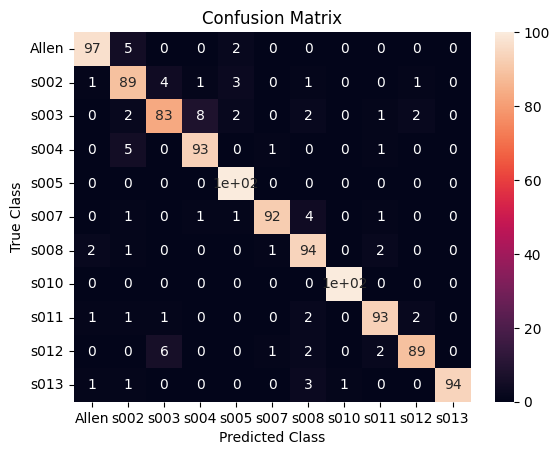

In [104]:
# Measure confusion matric on test data
best_pipeline = Pipeline([("scaler", StandardScaler()),("svm", SVC(C=grid.best_params_['svm__C']
                                                                   ,degree=grid.best_params_['svm__degree']
                                                                   ,kernel='poly'))])
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

print("Confusion matrix:\n{}".format(confusion_matrix(y_test,y_pred)))

score_image1 = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, xticklabels=enc.classes_,
                          yticklabels=enc.classes_)
score_image1.set(xlabel='Predicted Class', ylabel='True Class', title='Confusion Matrix')

# Classification reporting
print(classification_report(y_test, y_pred))

### B) Gradient Boost Ensemble

In [14]:
mlflow.sklearn.autolog()

experiment_name = "Evaluation Experiment on Gradient Boosting Ensemble"
experiment = mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name="Gradient Boost Classifier", experiment_id=experiment.experiment_id):

    # Create Pipeline for scaling and Gradient Boost model on rgf kernel
    #mypipeline = Pipeline([("scaler", StandardScaler()),("gboost", GradientBoostingClassifier(random_state=42))])
    clf = GradientBoostingClassifier(random_state=42)
    
    # Run grid search
    param_grid = {'n_estimators': [100, 200, 300],
                 'learning_rate': [0.01, 0.1, 1, 10],
                 'subsample': [0.8, 0.9, 1.0]}

    grid = GridSearchCV(clf, param_grid=param_grid, cv=10)
    grid.fit(X_train_scaled, y_train)


    run_id = mlflow.last_active_run().info.run_id
    print("Logged data and model in run {}".format(run_id))


2023/08/16 21:53:20 INFO mlflow.tracking.fluent: Experiment with name 'Evaluation Experiment on Gradient Boosting Ensemble' does not exist. Creating a new experiment.
2023/08/16 23:57:36 INFO mlflow.sklearn.utils: Logging the 5 best runs, 31 runs will be omitted.


Logged data and model in run 76ada3ddf52047ca90c66eb94e05a671


In [13]:
clf = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, subsample=0.9)
clf.fit(X_train_scaled, y_train)
print("Training score", cross_val_score(clf, scaler.transform(X_test), y_test, cv=10))

clf.score(scaler.transform(X_test), y_test)

Training score [0.9009009  0.95495495 0.94594595 0.91891892 0.90909091 0.90909091
 0.93636364 0.98181818 0.93636364 0.92727273]


0.9619565217391305

In [17]:
# Print results of run
print("Best cross validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(scaler.transform(X_test), y_test)))
print("Best parameters: {}".format(grid.best_params_))


Best cross validation accuracy: 0.97
Test set score: 0.97
Best parameters: {'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.9}


2023/08/17 03:09:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8c8677352cfa4c16a9973897aa0f25a4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Confusion matrix:
[[100   2   0   1   0   0   1   0   0   0   0]
 [  0  96   0   0   1   0   1   0   0   2   0]
 [  0   1  98   0   0   0   0   0   0   1   0]
 [  1   6   0  93   0   0   0   0   0   0   0]
 [  0   0   1   0  98   0   0   1   0   0   0]
 [  0   0   0   0   2  95   2   0   0   0   1]
 [  0   0   0   1   0   0  98   0   0   0   1]
 [  0   0   0   0   0   0   0 100   0   0   0]
 [  0   1   1   0   0   0   4   0  92   2   0]
 [  0   1   3   0   0   0   2   0   0  94   0]
 [  0   1   0   0   0   0   3   0   0   0  96]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       104
           1       0.89      0.96      0.92       100
           2       0.95      0.98      0.97       100
           3       0.98      0.93      0.95       100
           4       0.97      0.98      0.98       100
           5       1.00      0.95      0.97       100
           6       0.88      0.98      0.93       100
           7       0.99      1.

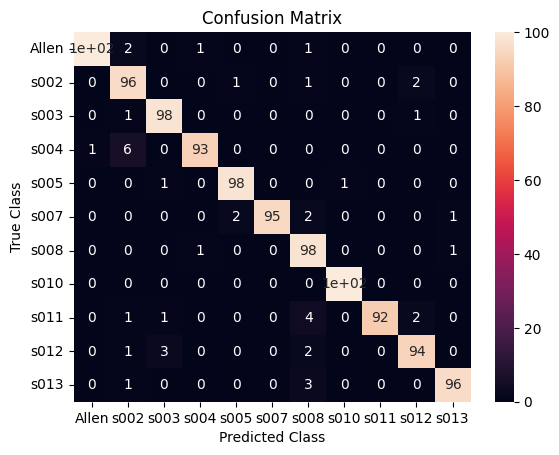

In [16]:
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(scaler.transform(X_test))

print("Confusion matrix:\n{}".format(confusion_matrix(y_test,y_pred)))

score_image1 = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, xticklabels=enc.classes_,
                          yticklabels=enc.classes_)
score_image1.set(xlabel='Predicted Class', ylabel='True Class', title='Confusion Matrix')

# Classification reporting
print(classification_report(y_test, y_pred))